# Gene Set Performance in Alzheimer's Disease Classification: A Comparison of xQTL_Based Genes vs. Proxy-Based Genes


## Aim

To validate the necessity of incorporating xQTL data in the **image\_QTL** project, we aim to compare genes identified through xQTL mapping versus those identified based on physical proximity (within a ±500 kb window of colocalized variants). We will demonstrate that xQTL-derived genes are more biologically relevant in explaining Alzheimer's disease (AD) mechanisms from the following perspectives:

1. **Polygenic Risk Score (PRS) prediction**
2. **Overlap with established AD-associated genes**
3. **Functional enrichment analysis**

## Input

1. **xQTL genes**
   Genes identified by overlapping top xQTL loci with colocalized variants from multi-GWAS ColocBoost analysis, which includes 6 AD, 7 imaging, 2 aging, and 1 Parkinson’s disease (PD) GWAS datasets. Gene IDs and positional information are retrieved using the [gene\_annotation pipeline](xqtl-protocol/code/data_preprocessing/phenotype/gene_annotation.ipynb).

   * Details are available [here](../../AD/xQTL_overlap.ipynb)

3. **Proximity-based (proxy) genes**
   Genes identified based on physical proximity—within ±500 kb of colocalized variants. Gene annotations are derived using UCSC genome annotations and the following R packages:

   * `GenomicRanges`
   * `GenomicFeatures`
   * `TxDb.Hsapiens.UCSC.hg38.knownGene`
   * `org.Hs.eg.db`
   * `biomaRt`
   * `EnsDb.Hsapiens.v86`
   * Details are available [here](./gene_by_proximity.ipynb)
4. **AD case metadata**
   ROSMAP clinical information from:
   `/data/interactive_analysis/rf2872/FunGen_xQTL/2025/May/ROSMAP_clinical_metadata.tsv`

5. **Expression data**
   ROSMAP DLPFC expression matrix:
   `/data/eQTL/ROSMAP/DLPFC/analysis_ready/phenotype_preprocessing/DLPFC_samples_list.rnaseqc.gene_tpm.low_expression_filtered.outlier_removed.tmm.expression.remove_duplicates.bed.gz`

6. **Known AD gene list**
   Curated by the **ADSP Gene Verification Committee**, including:

   * **Table 1**: Genes with GWAS evidence
   * **Table 2**: Genes with functional evidence
   * Available at: [ADSP GVC Top Hits List](https://adsp.niagads.org/gvc-top-hits-list/)

## Conclusion:

1. **Polygenic Risk Score (PRS) prediction**
* While proximity-based genes yield stronger predictive performance at scale, xQTL-derived genes demonstrate greater efficiency and signal quality. The top 20 genes for the two gene set are distinctly different, supporting the idea that xQTL mapping identifies distinct biological signals not captured by proximity alone.

2. **Overlap with established AD-associated genes**
* While proximity-based genes captureds more established AD-associated genes, too much noise might hinder the causal gene investigation.

3. **Functional enrichment analysis**
* AD_xQTL genes are enriched in pathways such as amyloid-beta metabolic process, tau protein binding, and membrane-associated organelles like the endosome—aligning closely with established hypotheses of Alzheimer's disease (AD) pathogenesis.

* In contrast, AD_proxy genes show enrichment in broad and less specific categories, including immune regulation, cytidine/deoxycytidine deaminase activity, and sialic acid binding, despite greater significance. These genes are scattered across diverse biological functions, making them difficult to interpret and less biologically compelling in the context of AD.

4. **Data in Nature**
* By demonstrating how a genetic variant impacts gene expression, splicing, protein levels, and epigenetic regulation, xQTLs provide the first functional link in a disease's causal chain. Analyzing this multi-layered evidence across various cell types and tissues yields specific, testable hypotheses for understanding disease mechanisms in the human body.


* Proximity-based methods only give you a location. It tells you a geneis near a variant, but it doesn't tell you if the variant has any effect on that gene. The variant could be affecting a different gene much further away, or it might not affect any gene at all. It leaves you with a list of potential candidates without a clear functional starting point for investigation.


In [1]:
library(tidyverse)
library(data.table)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.3.0
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.1.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




In [2]:
AD = fread("AD_proxy_genes.tsv")
Aging = fread("Aging_proxy_genes.tsv")
#PD = fread("PD_proxy_genes.tsv")
DNE = fread("DNE_proxy_genes.tsv")

AD_gene = unique(AD$ENSG_ID)
Aging_gene = unique(Aging$ENSG_ID)
#PD_gene = unique(PD$ENSG_ID)
DNE_gene = unique(DNE$ENSG_ID)

In [3]:
AD_xQTL = fread("~/xqtl-analysis/production/image_QTL/interested_genes/CB_M1/AD/annotated_AD_gene.tsv")
Aging_xQTL = fread("~/xqtl-analysis/production/image_QTL/interested_genes/CB_M1/Aging/annotated_Aging_gene.tsv")
#PD_xQTL = fread("PD_proxy_genes.tsv")
DNE_xQTL = fread("~/xqtl-analysis/production/image_QTL/interested_genes/CB_M1/DNE/genes_comparison/annotated_dne_gene.tsv")

## 1. PRS model- Ridge regression

For gene set comparison purpuse, Ridge regression is the optimal algorithm:
1. Feature nature: Features are continuous, numeric, high dimensional gene expression data
2. Fair Comparison: No feature selection, each gene set maintains its complete identity
3. Handles Multicollinearity: Common in gene expression data
4. Regularization Only: Shrinks coefficients without eliminating genes
5. Interpretable: Can examine which genes contribute most

In [14]:
library(pROC)
library(ggplot2)
library(caret)

In [4]:
exp_raw <- fread('/data/eQTL/ROSMAP/DLPFC/analysis_ready/phenotype_preprocessing/DLPFC_samples_list.rnaseqc.gene_tpm.low_expression_filtered.outlier_removed.tmm.expression.remove_duplicates.bed.gz')

In [5]:
exp_raw %>% head

#chr,start,end,gene_id,SM-CTDS5,SM-CJIXK,SM-CJGH9,SM-CTDS7,SM-CJGLT,SM-CTDT7,...,RISK_442,RISK_45_rerun,SM-CTEGK,RISK_51_rerun,RISK_67_rerun,RISK_73_redo,RISK_81,SM-CTEE8,RISK_93,RISK_97
<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,29569,29570,ENSG00000227232,0.86713223,0.4357151,-0.3668001,0.006811543,0.2688521,1.79619337,...,-0.2383699,-1.377110,-0.5275293,-0.4862194,-1.43189486,-1.5490204,-2.685304,-1.5959174,-2.6098584,-0.9006891
chr1,52472,52473,ENSG00000268020,-0.07955121,1.6378678,0.2688521,-0.182650237,0.2081076,-0.02270692,...,-1.1703806,-1.170381,-1.1703806,-1.1703806,-1.17038063,0.7120250,-1.170381,-0.4307273,-1.1703806,-0.4034813
chr1,57597,57598,ENSG00000240361,-0.08410743,1.5720367,0.9143990,-0.027249331,0.8905169,-0.11376979,...,-1.2334946,-1.233495,-0.5458851,-1.2334946,-0.62127258,-1.2334946,-1.233495,-1.2334946,-1.2334946,-0.5912576
chr1,65418,65419,ENSG00000186092,-0.39610308,1.5798971,0.9638026,-0.271206929,0.9352923,-0.76268350,...,-1.1243382,-1.875759,-0.6240288,-0.4257502,-0.93529230,1.3654825,-1.172635,-1.2888111,-1.8757588,-1.8757588
chr1,133722,133723,ENSG00000238009,0.10691669,0.8804360,0.6916925,0.217397537,-0.2150733,0.77795727,...,-0.3789700,-1.757666,0.4836656,-1.7576660,-0.03633594,0.4862194,-1.757666,0.9783555,-0.5804752,0.3474399
chr1,135894,135895,ENSG00000268903,2.78006615,1.8077066,0.4658759,0.897288076,1.2190477,0.36922970,...,-1.3626043,-1.362604,-1.3626043,-1.3626043,-1.36260432,-1.3626043,-1.362604,-1.3626043,-1.3626043,-1.3626043


In [6]:
exp <- exp_raw %>% select(-c(1:3)) %>% t()
colnames(exp) <- exp[1,]
exp <- exp[-1,]

In [44]:
AD_xQTL %>% head
AD_xQTL %>% dim

#chr,start,end,gene_id,strand,gene_name,event_ID
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chr1,23956838,23963461,ENSG00000189266,+,PNRC2,AD_Bellenguez; AD_Bellenguez_EADB_2022
chr1,23964346,23980926,ENSG00000188529,-,SRSF10,AD_Bellenguez; AD_Bellenguez_EADB_2022
chr1,161215233,161220698,ENSG00000158869,+,FCER1G,AD_Bellenguez; AD_Wightman_Excluding23andMe_2021
chr1,200891047,200915741,ENSG00000163362,+,INAVA,AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021
chr1,200969389,201023713,ENSG00000116852,-,KIF21B,AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021
chr1,207034365,207081023,ENSG00000123836,+,PFKFB2,AD_Bellenguez; AD_Kunkle_Stage1_2019; AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021; AD_Wightman_ExcludingUKBand23andME_2021; AD_Bellenguez_EADB_2022


[1] 153   7

In [7]:
meta <- fread('/data/interactive_analysis/rf2872/FunGen_xQTL/2025/May/ROSMAP_clinical_metadata.tsv')
exp_meta <- meta %>% filter(specimenID %in% rownames(exp)) %>% select(specimenID, group)

In [8]:
exp_meta <- exp_meta %>% arrange(match(specimenID, colnames(exp_raw))) 

In [9]:
head(exp_meta)

specimenID,group
<chr>,<chr>
SM-CTDS5,ad
SM-CJIXK,non_ad
SM-CJGH9,ad
SM-CTDS7,ad
SM-CJGLT,non_ad
SM-CTDT7,non_ad


### AD

In [93]:
proxy_AD_exp <- exp_raw %>% filter(gene_id %in% AD_gene) 
rownames(proxy_AD_exp) <- proxy_AD_exp$gene_id
proxy_AD_exp_t <- proxy_AD_exp %>% select(any_of(exp_meta$specimenID)) %>% t

In [94]:
head(proxy_AD_exp_t)
dim(proxy_AD_exp_t)

SM-CTDS5,0.4684081,-0.5670913,0.6974723,0.428237440,-0.03406404,0.5538082,1.00810138,0.7505915,0.1688152,-0.2127503,...,-0.07044361,-0.05679293,0.02952074,-0.2150733,0.1274924,-0.07499663,-0.13436249,1.03876715,1.1415931,-1.7849134
SM-CJIXK,0.7779573,-0.2453836,1.3540368,-0.173423136,1.15476077,0.1711187,0.53014054,-0.7003710,0.4862194,0.1481221,...,-0.79030815,-0.70327553,0.73562898,-0.2360346,0.3067181,-0.76572394,0.04088032,0.85725432,0.6546686,-0.6434571
SM-CJGH9,-0.1895807,-1.6040835,-0.1092005,0.777957272,0.76572394,2.0019524,0.64905265,-0.2735632,-1.3829941,-1.5415277,...,0.61029461,-0.53537394,-1.35403680,-1.4131600,-0.1481221,-0.50418635,-0.61577432,0.04088032,-0.2477242,0.3740954
SM-CTDS7,0.8185495,-0.4785675,1.1243382,-0.006811543,-0.12062823,0.2948402,1.49828981,0.9857102,0.1942061,-0.7626835,...,-0.10691669,-0.20115202,1.06642429,-0.3985601,0.1942061,-0.62127258,-1.11161354,0.57779016,0.3936485,-0.2877335
SM-CJGLT,0.7032755,-0.2782804,1.0584396,0.116055324,1.90979650,0.9458935,0.04542555,-0.8345245,-0.1665125,-0.6157743,...,-0.20578799,0.15271480,-1.21904770,-1.2142882,-0.1000686,-0.88714656,-0.11148484,-0.08182911,-0.2877335,-0.1872696
SM-CTDT7,-0.3985601,-0.6048332,0.2712069,0.717888423,0.29721241,1.3771099,-0.72082939,0.7626835,-1.1817149,-0.8737648,...,1.69234764,0.17803479,-0.73265625,-1.2001722,0.4990366,1.52679661,-0.34502914,-0.88378628,-0.8249142,0.3814107


[1]  806 1023

Training enhanced model for Proxy Gene Set ...
Training enhanced model for xQTL Gene Set ...

=== DIAGNOSTICS FOR Proxy Gene Set ===
Coefficient statistics:
  Non-zero coefficients: 1023 / 1023 
  Mean |coefficient|: 0.0077 
  Max |coefficient|: 0.0496 
Top 10 contributing genes:
               Gene Coefficient
922 ENSG00000196337 -0.04960115
343 ENSG00000120903 -0.04365957
101 ENSG00000176601  0.03818680
165 ENSG00000120314  0.03177735
905 ENSG00000176920 -0.03086229
912 ENSG00000087076  0.02972164
44  ENSG00000132185  0.02962411
11  ENSG00000185436  0.02905661
706 ENSG00000180336  0.02870174
698 ENSG00000004939 -0.02862168

=== DIAGNOSTICS FOR xQTL Gene Set ===
Coefficient statistics:
  Non-zero coefficients: 145 / 145 
  Mean |coefficient|: 0.097 
  Max |coefficient|: 0.3028 
Top 10 contributing genes:
               Gene Coefficient
64  ENSG00000172247  -0.3028280
77  ENSG00000186815  -0.3002391
73  ENSG00000095585  -0.2844348
138 ENSG00000198089   0.2833997
6   ENSG00000123836   0

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases




=== ENHANCED PERFORMANCE ANALYSIS ===
                     Gene_Set N_Features CV_AUC CV_Sens CV_Spec Test_AUC
Proxy Gene Set Proxy Gene Set       1023 0.7125  0.8738  0.3623   0.7728
xQTL Gene Set   xQTL Gene Set        145 0.6516  0.7912  0.4118   0.7283
               Optimal_Lambda AUC_CI_Lower AUC_CI_Upper AUC_per_Feature
Proxy Gene Set       0.788046       0.7139       0.8319        0.000755
xQTL Gene Set        0.032903       0.6574       0.7962        0.005023

=== TOP GENE OVERLAP ANALYSIS ===
Top 20 genes from Proxy Gene Set : 20 
Top 20 genes from xQTL Gene Set : 20 
Overlapping genes: 0 
Overlap percentage: 0 %

=== RECOMMENDATIONS FOR GENE EXPRESSION ANALYSIS ===
1. BEST PERFORMING GENE SET: Proxy Gene Set 
   Test AUC: 0.7728 

2. MOST EFFICIENT GENE SET: xQTL Gene Set 
   AUC per feature: 0.005023 

3. REGULARIZATION INSIGHTS:
   Proxy Gene Set : <U+03BB> = 0.788046 (moderate regularization)
   xQTL Gene Set : <U+03BB> = 0.032903 (low regularization - clean features)

4

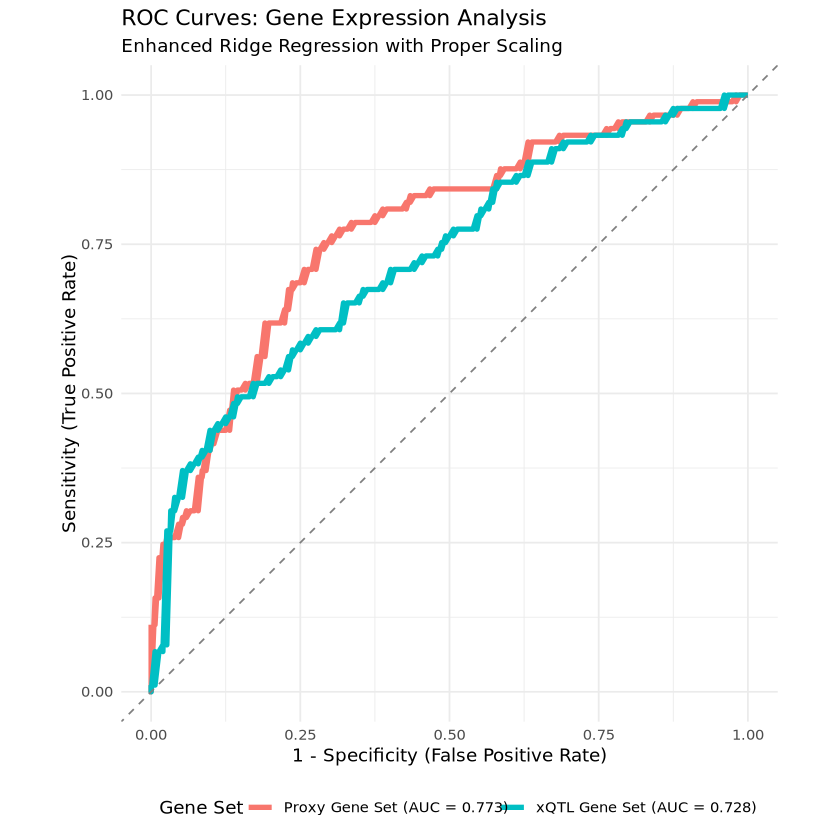

In [96]:
library(dplyr)
library(stringr)
library(caret)
library(pROC)
library(ggplot2)
library(glmnet)

# Function to process xQTL expression data
process_xQTL_exp <- function(exp_raw, gene_ids, exp_meta) {
  exp_data <- exp_raw %>% 
    filter(gene_id %in% gene_ids) %>% 
    column_to_rownames("gene_id") %>% 
    select(any_of(exp_meta$specimenID)) %>% 
    t()
  return(exp_data)
}


# Store gene sets for different n_methods thresholds
gene_sets <- list(
  "Proxy Gene Set" = list(genes = AD_gene, is_matrix = TRUE),
  "xQTL Gene Set" = list(genes = AD_xQTL$gene_id, is_matrix = FALSE)
)

# Prepare labels
labels <- exp_meta %>% 
  mutate(labels = ifelse(group == 'ad', 1, 0)) %>% 
  pull(labels)

# Process datasets and remove near-zero variance predictors
data_list <- lapply(names(gene_sets), function(set_name) {
  if (gene_sets[[set_name]]$is_matrix) {
    data <- data.frame(proxy_AD_exp_t, Disease = as.factor(labels))
    colnames(data)[1:length(proxy_AD_exp$gene_id)] <- proxy_AD_exp$gene_id
  } else {
    exp_data <- process_xQTL_exp(exp_raw, gene_sets[[set_name]]$genes, exp_meta)
    data <- data.frame(exp_data, Disease = as.factor(labels))
  }
  # Remove near-zero variance predictors
  nzv <- nearZeroVar(data[, -ncol(data)], saveMetrics = TRUE)
  data <- data[, !nzv$zeroVar & !nzv$nzv]
  return(data)
})
names(data_list) <- names(gene_sets)

# =============================================================================
# GENE EXPRESSION-OPTIMIZED ANALYSIS
# =============================================================================

library(caret)
library(glmnet)
library(pROC)

# =============================================================================
# ENHANCED PREPROCESSING FOR GENE EXPRESSION
# =============================================================================

preprocess_gene_expression <- function(data_list) {
  processed_list <- lapply(data_list, function(data) {
    
    # Separate features and target
    features <- data[, -ncol(data)]
    target <- data[, ncol(data)]
    
    # Check if log transformation is needed
    if(max(features, na.rm = TRUE) > 50) {
      cat("Applying log2 transformation...\n")
      features <- log2(features + 1)
    }
    
    # Remove near-zero variance (already done, but ensuring)
    nzv <- nearZeroVar(features, saveMetrics = TRUE)
    features <- features[, !nzv$zeroVar & !nzv$nzv]
    
    # Center and scale features (crucial for Ridge)
    preprocessor <- preProcess(features, method = c("center", "scale"))
    features_scaled <- predict(preprocessor, features)
    
    # Combine back
    processed_data <- data.frame(features_scaled, Disease = target)
    
    return(list(
      data = processed_data,
      preprocessor = preprocessor,
      n_features = ncol(features_scaled)
    ))
  })
  
  return(processed_list)
}

# Apply enhanced preprocessing
processed_results <- preprocess_gene_expression(data_list)
train_data_processed <- lapply(processed_results, function(x) x$data[trainIndex, ])
test_data_processed <- lapply(processed_results, function(x) x$data[-trainIndex, ])

# =============================================================================
# OPTIMIZED RIDGE REGRESSION FOR GENE EXPRESSION
# =============================================================================

# Enhanced cross-validation for gene expression
set.seed(123)
control_enhanced <- trainControl(
  method = "repeatedcv", 
  number = 10, 
  repeats = 5,
  classProbs = TRUE, 
  summaryFunction = twoClassSummary,
  savePredictions = "final",  # Save for ensemble methods
  allowParallel = TRUE        # Speed up if you have multiple cores
)

# Optimized lambda sequence for gene expression
# Gene expression often needs stronger regularization
ridge_grid_enhanced <- expand.grid(
  alpha = 0, 
  lambda = exp(seq(log(0.001), log(10), length = 30))  # Log-spaced lambda values
)

# Train enhanced models
models_enhanced <- lapply(names(train_data_processed), function(set_name) {
  cat("Training enhanced model for", set_name, "...\n")
  
  data <- train_data_processed[[set_name]]
  
  # Prepare data
  x <- as.matrix(data[, -ncol(data)])
  y <- factor(data$Disease, 
              levels = c("0", "1"),
              labels = c("Control", "Case"))
  
  # Train model
  model <- train(x = x, y = y,
                method = "glmnet",
                trControl = control_enhanced,
                tuneGrid = ridge_grid_enhanced,
                metric = "ROC")
  
  return(model)
})

names(models_enhanced) <- names(train_data_processed)

# =============================================================================
# GENE EXPRESSION-SPECIFIC DIAGNOSTICS
# =============================================================================

# Check for batch effects or technical artifacts
diagnostic_plots <- function(models, data_list) {
  
  for(i in seq_along(models)) {
    set_name <- names(models)[i]
    model <- models[[i]]
    
    cat("\n=== DIAGNOSTICS FOR", set_name, "===\n")
    
    # 1. Lambda path
    plot(model, main = paste("Lambda Tuning -", set_name))
    
    # 2. Coefficient distribution
    coefs <- coef(model$finalModel, s = model$bestTune$lambda)
    coef_values <- as.numeric(coefs[-1, 1])  # Remove intercept
    
    cat("Coefficient statistics:\n")
    cat("  Non-zero coefficients:", sum(coef_values != 0), "/", length(coef_values), "\n")
    cat("  Mean |coefficient|:", round(mean(abs(coef_values)), 4), "\n")
    cat("  Max |coefficient|:", round(max(abs(coef_values)), 4), "\n")
    
    # 3. Top contributing genes
    coef_df <- data.frame(
      Gene = rownames(coefs)[-1],
      Coefficient = coef_values
    )
    coef_df$Abs_Coef <- abs(coef_df$Coefficient)
    coef_df <- coef_df[order(coef_df$Abs_Coef, decreasing = TRUE), ]
    
    cat("Top 10 contributing genes:\n")
    print(head(coef_df[, c("Gene", "Coefficient")], 10))
  }
}

# Run diagnostics
diagnostic_plots(models_enhanced, train_data_processed)

# =============================================================================
# ENHANCED PREDICTIONS AND EVALUATION
# =============================================================================

# Make predictions with enhanced models
predictions_enhanced <- mapply(function(model, test) {
  predict(model, newdata = test, type = "prob")[, "Case"]
}, models_enhanced, test_data_processed, SIMPLIFY = FALSE)

# Enhanced ROC analysis
roc_enhanced <- mapply(function(pred, test, name) {
  roc_obj <- roc(test$Disease, pred)
  roc_obj$gene_set <- name
  return(roc_obj)
}, predictions_enhanced, test_data_processed, names(gene_sets), SIMPLIFY = FALSE)

# =============================================================================
# GENE EXPRESSION-SPECIFIC PERFORMANCE METRICS
# =============================================================================

cat("\n=== ENHANCED PERFORMANCE ANALYSIS ===\n")

# Create comprehensive performance table
performance_enhanced <- data.frame(
  Gene_Set = names(roc_enhanced),
  N_Features = sapply(processed_results, function(x) x$n_features),
  CV_AUC = sapply(models_enhanced, function(m) round(max(m$results$ROC), 4)),
  CV_Sens = sapply(models_enhanced, function(m) {
    best_idx <- which.max(m$results$ROC)
    round(m$results$Sens[best_idx], 4)
  }),
  CV_Spec = sapply(models_enhanced, function(m) {
    best_idx <- which.max(m$results$ROC)
    round(m$results$Spec[best_idx], 4)
  }),
  Test_AUC = sapply(roc_enhanced, function(r) round(auc(r), 4)),
  Optimal_Lambda = sapply(models_enhanced, function(m) round(m$bestTune$lambda, 6)),
  stringsAsFactors = FALSE
)

# Add confidence intervals
for(i in seq_along(roc_enhanced)) {
  ci_result <- ci(roc_enhanced[[i]], method = "bootstrap", boot.n = 1000)
  performance_enhanced$AUC_CI_Lower[i] <- round(ci_result[1], 4)
  performance_enhanced$AUC_CI_Upper[i] <- round(ci_result[3], 4)
}

# Add feature efficiency
performance_enhanced$AUC_per_Feature <- round(
  performance_enhanced$Test_AUC / performance_enhanced$N_Features, 6
)

print(performance_enhanced)

# =============================================================================
# GENE PATHWAY ANALYSIS (if gene annotations available)
# =============================================================================

# Function to analyze top genes (you can enhance this with pathway databases)
analyze_top_genes <- function(models, n_top = 20) {
  
  top_genes_list <- list()
  
  for(i in seq_along(models)) {
    set_name <- names(models)[i]
    model <- models[[i]]
    
    # Get coefficients
    coefs <- coef(model$finalModel, s = model$bestTune$lambda)
    coef_df <- data.frame(
      Gene = rownames(coefs)[-1],
      Coefficient = as.numeric(coefs[-1, 1])
    )
    coef_df$Abs_Coefficient <- abs(coef_df$Coefficient)
    coef_df <- coef_df[order(coef_df$Abs_Coefficient, decreasing = TRUE), ]
    
    top_genes_list[[set_name]] <- head(coef_df, n_top)
  }
  
  return(top_genes_list)
}

top_genes <- analyze_top_genes(models_enhanced, 20)

# Compare overlap between gene sets
if(length(top_genes) == 2) {
  genes1 <- top_genes[[1]]$Gene
  genes2 <- top_genes[[2]]$Gene
  
  overlap <- intersect(genes1, genes2)
  
  cat("\n=== TOP GENE OVERLAP ANALYSIS ===\n")
  cat("Top 20 genes from", names(top_genes)[1], ":", length(genes1), "\n")
  cat("Top 20 genes from", names(top_genes)[2], ":", length(genes2), "\n")
  cat("Overlapping genes:", length(overlap), "\n")
  cat("Overlap percentage:", round(length(overlap) / 20 * 100, 1), "%\n")
  
  if(length(overlap) > 0) {
    cat("Overlapping genes:", paste(overlap, collapse = ", "), "\n")
  }
}

# =============================================================================
# FINAL RECOMMENDATIONS FOR GENE EXPRESSION DATA
# =============================================================================

cat("\n=== RECOMMENDATIONS FOR GENE EXPRESSION ANALYSIS ===\n")

best_gene_set <- performance_enhanced$Gene_Set[which.max(performance_enhanced$Test_AUC)]
most_efficient <- performance_enhanced$Gene_Set[which.max(performance_enhanced$AUC_per_Feature)]

cat("1. BEST PERFORMING GENE SET:", best_gene_set, "\n")
cat("   Test AUC:", performance_enhanced$Test_AUC[performance_enhanced$Gene_Set == best_gene_set], "\n")

cat("\n2. MOST EFFICIENT GENE SET:", most_efficient, "\n")
cat("   AUC per feature:", performance_enhanced$AUC_per_Feature[performance_enhanced$Gene_Set == most_efficient], "\n")

cat("\n3. REGULARIZATION INSIGHTS:\n")
for(i in seq_along(performance_enhanced$Gene_Set)) {
  set_name <- performance_enhanced$Gene_Set[i]
  lambda_val <- performance_enhanced$Optimal_Lambda[i]
  cat("  ", set_name, ": λ =", lambda_val)
  
  if(lambda_val > 1) {
    cat(" (high regularization - likely noisy features)\n")
  } else if(lambda_val > 0.1) {
    cat(" (moderate regularization)\n") 
  } else {
    cat(" (low regularization - clean features)\n")
  }
}

cat("\n4. BIOLOGICAL INTERPRETATION:\n")
cat("   Lower optimal lambda suggests higher quality, more relevant genes\n")
cat("   Higher AUC per feature indicates better biological signal\n")
cat("   Ridge regression preserves co-expression networks\n")

# Generate final plots
library(ggplot2)

# Enhanced ROC comparison
roc_data_enhanced <- do.call(rbind, lapply(seq_along(roc_enhanced), function(i) {
  roc_obj <- roc_enhanced[[i]]
  data.frame(
    Sensitivity = roc_obj$sensitivities,
    Specificity = roc_obj$specificities,
    Gene_Set = names(roc_enhanced)[i],
    AUC = round(auc(roc_obj), 3)
  )
}))

roc_data_enhanced$Gene_Set_AUC <- paste0(roc_data_enhanced$Gene_Set, 
                                        " (AUC = ", roc_data_enhanced$AUC, ")")

p_enhanced <- ggplot(roc_data_enhanced, aes(x = 1 - Specificity, y = Sensitivity, 
                                           color = Gene_Set_AUC)) +
  geom_line(size = 1.5) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray50") +
  labs(title = "ROC Curves: Gene Expression Analysis",
       subtitle = "Enhanced Ridge Regression with Proper Scaling",
       x = "1 - Specificity (False Positive Rate)",
       y = "Sensitivity (True Positive Rate)",
       color = "Gene Set") +
  theme_minimal() +
  theme(legend.position = "bottom") +
  coord_equal()

print(p_enhanced)

In [102]:
AD |> filter(ENSG_ID %in% genes1) |> count(SYMBOL)

SYMBOL,n
<chr>,<int>
CARD8-AS1,36
CGB7,36
CHRNA2,12
CREBZF,2
DDB2,45
EMP3,36
FAM24B,24
FCRLA,2
FUT2,36


In [103]:
AD_xQTL |> filter(gene_id %in% genes2)

#chr,start,end,gene_id,strand,gene_name,event_ID
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chr1,200891047,200915741,ENSG00000163362,+,INAVA,AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021
chr1,207034365,207081023,ENSG00000123836,+,PFKFB2,AD_Bellenguez; AD_Kunkle_Stage1_2019; AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021; AD_Wightman_ExcludingUKBand23andME_2021; AD_Bellenguez_EADB_2022
chr2,134455758,134718999,ENSG00000152128,-,TMEM163,AD_Bellenguez; AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021
chr4,17800654,17810757,ENSG00000163257,-,DCAF16,AD_Bellenguez_EADB_2022; Telomere_pc1; mvage
chr5,14664663,14699849,ENSG00000154124,+,OTULIN,AD_Bellenguez; AD_Bellenguez_EADB_2022
chr5,157085831,157142868,ENSG00000135077,-,HAVCR2,AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021; AD_Wightman_ExcludingUKBand23andME_2021
chr7,100456619,100464259,ENSG00000185955,-,C7orf61,AD_Bellenguez; AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021; AD_Wightman_ExcludingUKBand23andME_2021; AD_Bellenguez_EADB_2022
chr8,27311481,27459390,ENSG00000120899,+,PTK2B,AD_Bellenguez; AD_Kunkle_Stage1_2019; AD_Wightman_Full_2021; AD_Wightman_Excluding23andMe_2021; AD_Wightman_ExcludingUKBand23andME_2021; AD_Bellenguez_EADB_2022
chr11,47177521,47186442,ENSG00000165912,-,PACSIN3,AD_Bellenguez; Telomere_pc1


## 2. Overlap with established AD-associated genes

In [4]:
Table1_gene = fread("~/xqtl-analysis/production/image_QTL/interested_genes/CB_M1/DNE/genes_comparison/Table1_gene_list.gene_list.tsv")
Table2_gene = fread("~/xqtl-analysis/production/image_QTL/interested_genes/CB_M1/DNE/genes_comparison/Table2_gene_list.gene_list.tsv")

In [5]:
library(UpSetR)

In [8]:

# Create named list of gene sets
gene_sets <- list(
  "Table1" = Table1_gene$gene_id,
  "Table2" = Table2_gene$gene_id, 
  "AD_xQTL" = AD_xQTL$gene_id,
  "AD" = AD$ENSG_ID
)

# Remove any NA values
gene_sets <- lapply(gene_sets, function(x) x[!is.na(x)])

                    # Convert to binary matrix for UpSet plot
all_genes <- unique(unlist(gene_sets))
upset_data <- data.frame(gene = all_genes)

for(set_name in names(gene_sets)) {
  upset_data[[set_name]] <- upset_data$gene %in% gene_sets[[set_name]]
}

                    
# Convert to proper format for UpSetR
upset_r_data <- upset_data
# Remove the 'gene' column and convert to 0/1 instead of TRUE/FALSE
upset_r_data <- upset_r_data[, -1]  # Remove gene column
upset_r_data <- as.data.frame(lapply(upset_r_data, as.numeric))

# Add row names if needed
rownames(upset_r_data) <- upset_data$gene

# Create UpSetR plot with proper error handling
tryCatch({
  upset_r_plot <- upset(upset_r_data, 
                       sets = names(gene_sets),
                       order.by = "freq",
                       decreasing = TRUE,
                       mb.ratio = c(0.6, 0.4),
                       number.angles = 0,
                       text.scale = 1.2,
                       point.size = 3,
                       line.size = 1.5,
                       mainbar.y.label = "Intersection Size",
                       sets.x.label = "Set Size",
                       sets.bar.color = "steelblue",
                       main.bar.color = "darkblue")
  
  cat("UpSetR plot created successfully\n")
}, error = function(e) {
  cat("UpSetR failed, using alternative method\n")
  
  # Alternative: Create a simple intersection matrix
  intersection_matrix <- matrix(0, nrow = length(all_genes), ncol = length(gene_sets))
  rownames(intersection_matrix) <- all_genes
  colnames(intersection_matrix) <- names(gene_sets)
  
  for(i in 1:length(gene_sets)) {
    intersection_matrix[all_genes %in% gene_sets[[i]], i] <- 1
  }
  
  print(head(intersection_matrix))
})


UpSetR plot created successfully


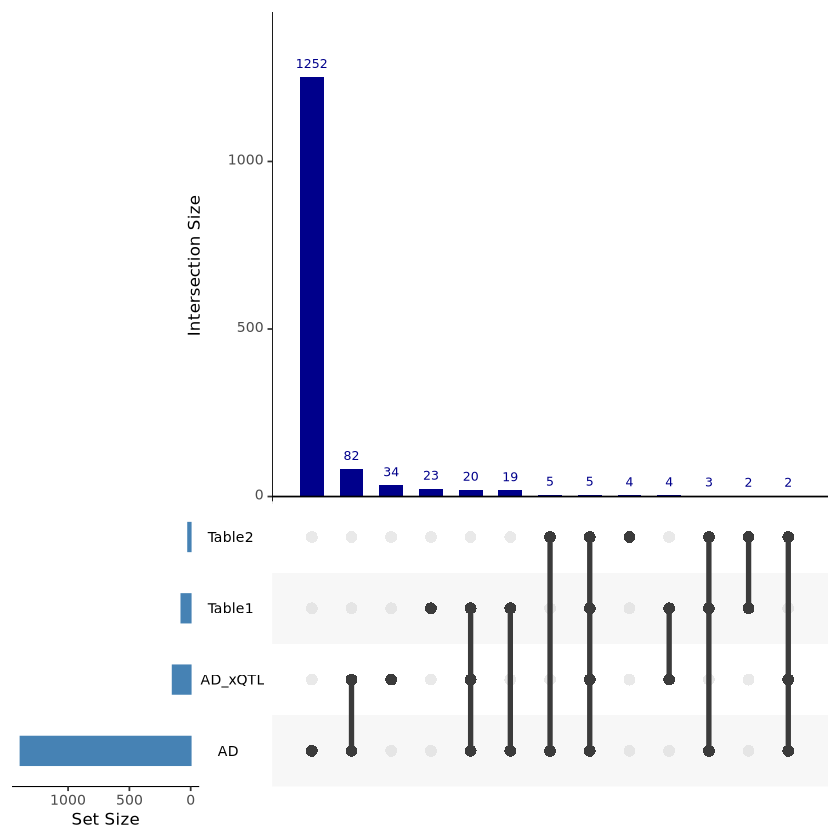

In [9]:
print(upset_r_plot)

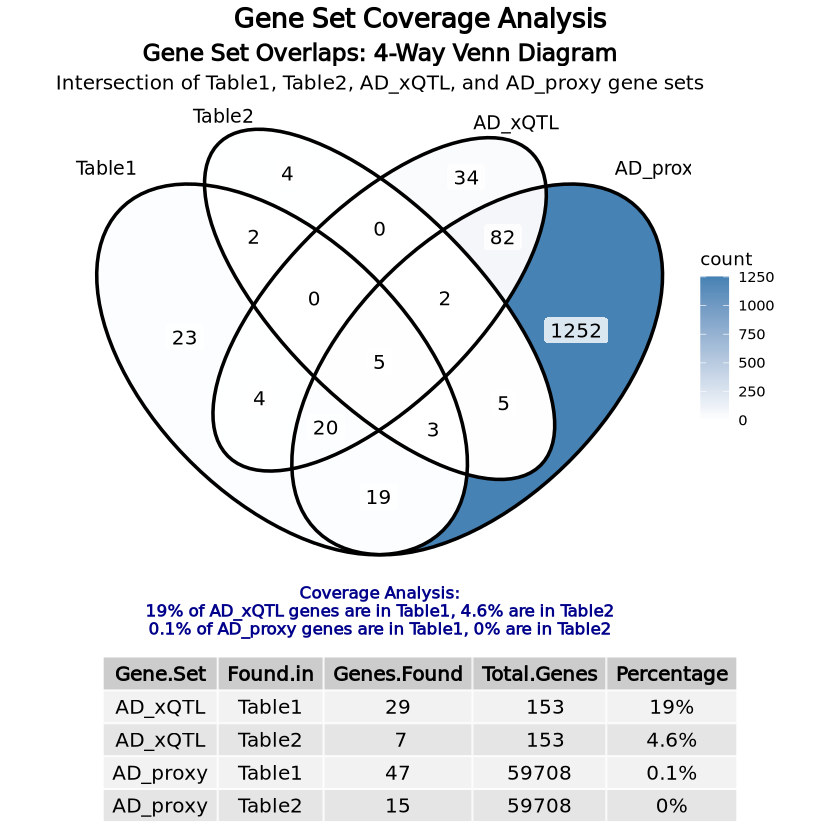

In [127]:
# Custom Venn Diagram with Explanatory Percentages
library(ggVennDiagram)
library(dplyr)
library(ggplot2)

# Assuming your gene sets are defined as:
gene_sets <- list(
  "Table1" = Table1_gene$gene_id,
  "Table2" = Table2_gene$gene_id, 
  "AD_xQTL" = AD_xQTL$gene_id,
  "AD_proxy" = AD$ENSG_ID  # Note: changed to AD_proxy as in your code
)

# Remove NAs
gene_sets <- lapply(gene_sets, function(x) x[!is.na(x)])

# Create a summary table alongside the plot
library(gridExtra)
library(grid)

# Create summary table
summary_df <- data.frame(
  "Gene Set" = c("AD_xQTL", "AD_xQTL", "AD_proxy", "AD_proxy"),
  "Found in" = c("Table1", "Table2", "Table1", "Table2"),
  "Genes Found" = c(
    percentages$counts$xqtl_in_table1,
    percentages$counts$xqtl_in_table2,
    percentages$counts$proxy_in_table1,
    percentages$counts$proxy_in_table2
  ),
  "Total Genes" = c(
    percentages$counts$ad_xqtl_total,
    percentages$counts$ad_xqtl_total,
    percentages$counts$ad_proxy_total,
    percentages$counts$ad_proxy_total
  ),
  "Percentage" = c(
    paste0(percentages$pct_xqtl_in_table1, "%"),
    paste0(percentages$pct_xqtl_in_table2, "%"),
    paste0(percentages$pct_proxy_in_table1, "%"),
    paste0(percentages$pct_proxy_in_table2, "%")
  )
)

# Convert to table grob
table_grob <- tableGrob(summary_df, rows = NULL, theme = ttheme_default())

# Combine plot and table
combined_plot <- grid.arrange(
  venn_plot_with_percentages,
  table_grob,
  ncol = 1,
  heights = c(3, 1),
  top = textGrob("Gene Set Coverage Analysis", 
                gp = gpar(fontsize = 16, fontface = "bold"))
)


## Functional Enrichment

In [128]:
library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:purrr':

    simplify


The following object is masked from 'package:lattice':

    dotplot


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:dplyr':

    combine

### AD_xQTL

In [129]:
AD_xQTL_ego <- enrichGO(
  gene          = AD_xQTL$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [131]:
head(AD_xQTL_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050435,GO:0050435,amyloid-beta metabolic process,7/132,73/21261,3.511056e-07,0.0008394934,0.0007062766,ENSG00000136717/ENSG00000120885/ENSG00000073921/ENSG00000137642/ENSG00000138613/ENSG00000159640/ENSG00000064687,7
GO:0042987,GO:0042987,amyloid precursor protein catabolic process,7/132,83/21261,8.498347e-07,0.0010159774,0.0008547548,ENSG00000151694/ENSG00000136717/ENSG00000120885/ENSG00000073921/ENSG00000137642/ENSG00000138613/ENSG00000064687,7
GO:1902992,GO:1902992,negative regulation of amyloid precursor protein catabolic process,5/132,34/21261,2.058477e-06,0.0012454519,0.0010478147,ENSG00000136717/ENSG00000120885/ENSG00000073921/ENSG00000137642/ENSG00000064687,5
GO:1905245,GO:1905245,regulation of aspartic-type peptidase activity,4/132,16/21261,2.438340e-06,0.0012454519,0.0010478147,ENSG00000136717/ENSG00000073921/ENSG00000137642/ENSG00000030582,4
GO:0070372,GO:0070372,regulation of ERK1 and ERK2 cascade,12/132,366/21261,3.096762e-06,0.0012454519,0.0010478147,ENSG00000119185/ENSG00000145901/ENSG00000135077/ENSG00000196126/ENSG00000146648/ENSG00000120899/ENSG00000102882/ENSG00000167711/ENSG00000161929/ENSG00000108861/ENSG00000064687/ENSG00000142192,12


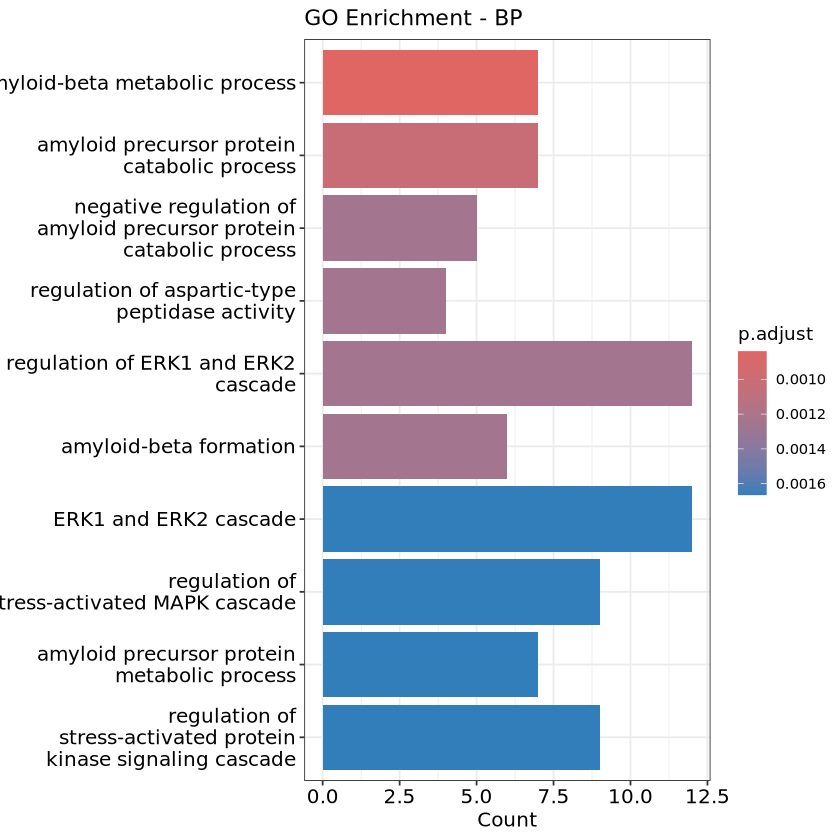

In [132]:
barplot(AD_xQTL_ego, showCategory = 10, title = "GO Enrichment - BP")

In [133]:
AD_xQTL_ego_cc <- enrichGO(
  gene          = AD_xQTL$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [134]:
head(AD_xQTL_ego_cc, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031252,GO:0031252,cell leading edge,12/141,461/22568,3.379800e-05,0.003379744,0.002966697,ENSG00000119185/ENSG00000151694/ENSG00000145715/ENSG00000198087/ENSG00000146648/ENSG00000120899/ENSG00000070756/ENSG00000107679/ENSG00000102879/ENSG00000161929/ENSG00000186868/ENSG00000064687,12
GO:0001772,GO:0001772,immunological synapse,5/141,59/22568,3.384237e-05,0.003379744,0.002966697,ENSG00000135077/ENSG00000196126/ENSG00000102879/ENSG00000161929/ENSG00000108861,5
GO:0001726,GO:0001726,ruffle,8/141,197/22568,3.437027e-05,0.003379744,0.002966697,ENSG00000119185/ENSG00000151694/ENSG00000145715/ENSG00000198087/ENSG00000146648/ENSG00000107679/ENSG00000161929/ENSG00000064687,8
GO:0098791,GO:0098791,Golgi apparatus subcompartment,12/141,485/22568,5.511425e-05,0.003487144,0.003060972,ENSG00000196126/ENSG00000196735/ENSG00000137642/ENSG00000168434/ENSG00000103365/ENSG00000030582/ENSG00000073969/ENSG00000176920/ENSG00000105538/ENSG00000100280/ENSG00000100211/ENSG00000142192,12
GO:0005770,GO:0005770,late endosome,11/141,413/22568,5.910414e-05,0.003487144,0.003060972,ENSG00000152128/ENSG00000196126/ENSG00000196735/ENSG00000065060/ENSG00000106460/ENSG00000146648/ENSG00000137642/ENSG00000102882/ENSG00000167716/ENSG00000030582/ENSG00000225190,11
GO:0005802,GO:0005802,trans-Golgi network,9/141,332/22568,2.475347e-04,0.012170455,0.010683076,ENSG00000196126/ENSG00000196735/ENSG00000137642/ENSG00000168434/ENSG00000103365/ENSG00000030582/ENSG00000100280/ENSG00000100211/ENSG00000142192,9
GO:0031901,GO:0031901,early endosome membrane,8/141,292/22568,5.117273e-04,0.020180905,0.017714550,ENSG00000152128/ENSG00000146648/ENSG00000137642/ENSG00000186815/ENSG00000103365/ENSG00000167716/ENSG00000029725/ENSG00000064687,8
GO:0150034,GO:0150034,distal axon,8/141,295/22568,5.472788e-04,0.020180905,0.017714550,ENSG00000188529/ENSG00000116852/ENSG00000136717/ENSG00000066248/ENSG00000120899/ENSG00000149930/ENSG00000186868/ENSG00000142192,8
GO:0030139,GO:0030139,endocytic vesicle,10/141,481/22568,9.058111e-04,0.028144190,0.024704624,ENSG00000196126/ENSG00000196735/ENSG00000204267/ENSG00000146648/ENSG00000159840/ENSG00000073921/ENSG00000100599/ENSG00000102879/ENSG00000161929/ENSG00000029725,10


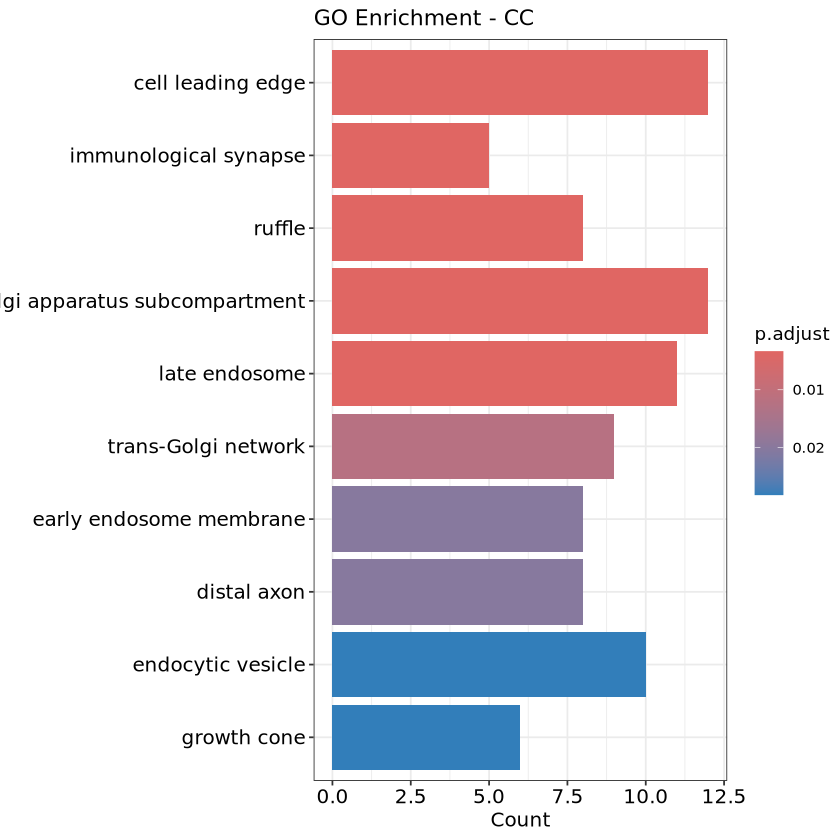

In [135]:
barplot(AD_xQTL_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [85]:
ggsave('~/project/image_QTL/image_enrichment/figs/image_AD_sig_xqtl_CC.pdf', width = 6, height = 6)

In [136]:
AD_xQTL_ego_mf <- enrichGO(
  gene          = AD_xQTL$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [137]:
head(AD_xQTL_ego_mf, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0048156,GO:0048156,tau protein binding,4/135,45/21059,0.0001962753,0.04416508,0.04142506,ENSG00000136717/ENSG00000120885/ENSG00000073921/ENSG00000149930,4
GO:0017124,GO:0017124,SH3 domain binding,6/135,136/21059,0.0002467323,0.04416508,0.04142506,ENSG00000151694/ENSG00000168918/ENSG00000198087/ENSG00000108091/ENSG00000159314/ENSG00000186868,6
GO:0004709,GO:0004709,MAP kinase kinase kinase activity,3/135,27/21059,0.0006732881,0.08034572,0.07536102,ENSG00000146648/ENSG00000149930/ENSG00000006062,3
GO:0051020,GO:0051020,GTPase binding,8/135,337/21059,0.0015100983,0.13515380,0.12676878,ENSG00000136717/ENSG00000145715/ENSG00000073921/ENSG00000137642/ENSG00000100599/ENSG00000103365/ENSG00000174943/ENSG00000105538,8
GO:0004875,GO:0004875,complement receptor activity,2/135,11/21059,0.0021601594,0.13713781,0.12862970,ENSG00000117322/ENSG00000203710,2


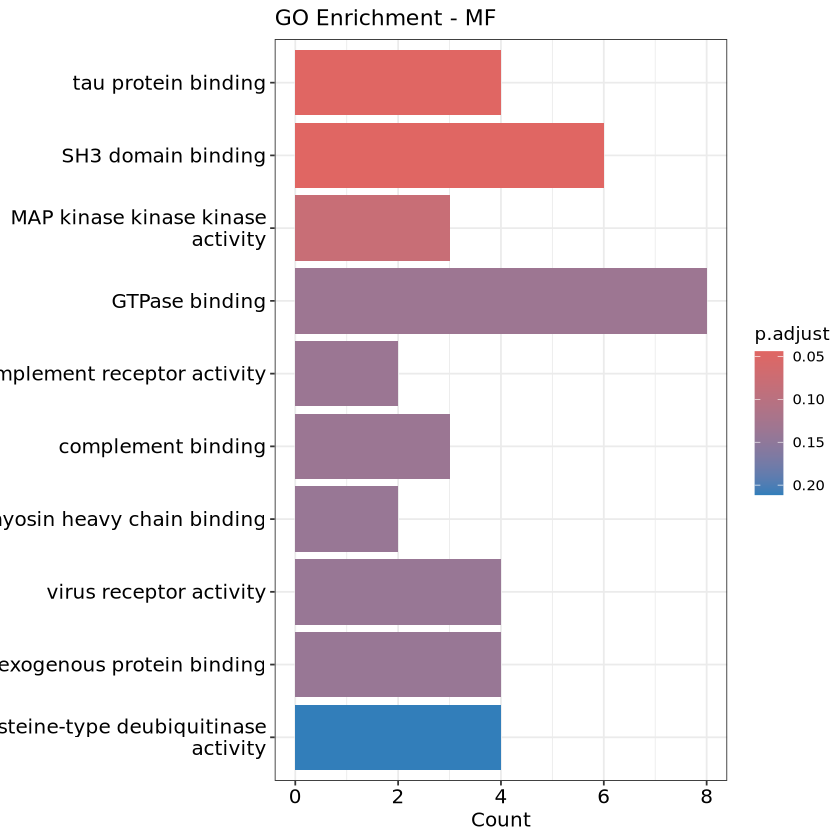

In [138]:
barplot(AD_xQTL_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

### AD_proxy

In [141]:
AD_proxy_ego <- enrichGO(
  gene          = AD_gene,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [142]:
head(AD_proxy_ego, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002924,GO:0002924,negative regulation of humoral immune response mediated by circulating immunoglobulin,8/1027,11/21261,4.181818e-09,1.864014e-05,1.783495e-05,ENSG00000203710/ENSG00000197721/ENSG00000117322/ENSG00000072694/ENSG00000117335/ENSG00000111679/ENSG00000123838/ENSG00000123843,8
GO:0002921,GO:0002921,negative regulation of humoral immune response,9/1027,17/21261,2.367318e-08,1.864014e-05,1.783495e-05,ENSG00000203710/ENSG00000197721/ENSG00000117322/ENSG00000196352/ENSG00000072694/ENSG00000117335/ENSG00000111679/ENSG00000123838/ENSG00000123843,9
GO:0045869,GO:0045869,negative regulation of single stranded viral RNA replication via double stranded DNA intermediate,9/1027,17/21261,2.367318e-08,1.864014e-05,1.783495e-05,ENSG00000243811/ENSG00000100298/ENSG00000262156/ENSG00000128394/ENSG00000133422/ENSG00000244509/ENSG00000132376/ENSG00000239713/ENSG00000179750,9
GO:0030449,GO:0030449,regulation of complement activation,10/1027,22/21261,2.517684e-08,1.864014e-05,1.783495e-05,ENSG00000203710/ENSG00000197721/ENSG00000117322/ENSG00000196352/ENSG00000117335/ENSG00000167085/ENSG00000095970/ENSG00000108561/ENSG00000123838/ENSG00000123843,10
GO:0006216,GO:0006216,cytidine catabolic process,8/1027,13/21261,2.990197e-08,1.864014e-05,1.783495e-05,ENSG00000124701/ENSG00000243811/ENSG00000100298/ENSG00000262156/ENSG00000128394/ENSG00000244509/ENSG00000239713/ENSG00000179750,8


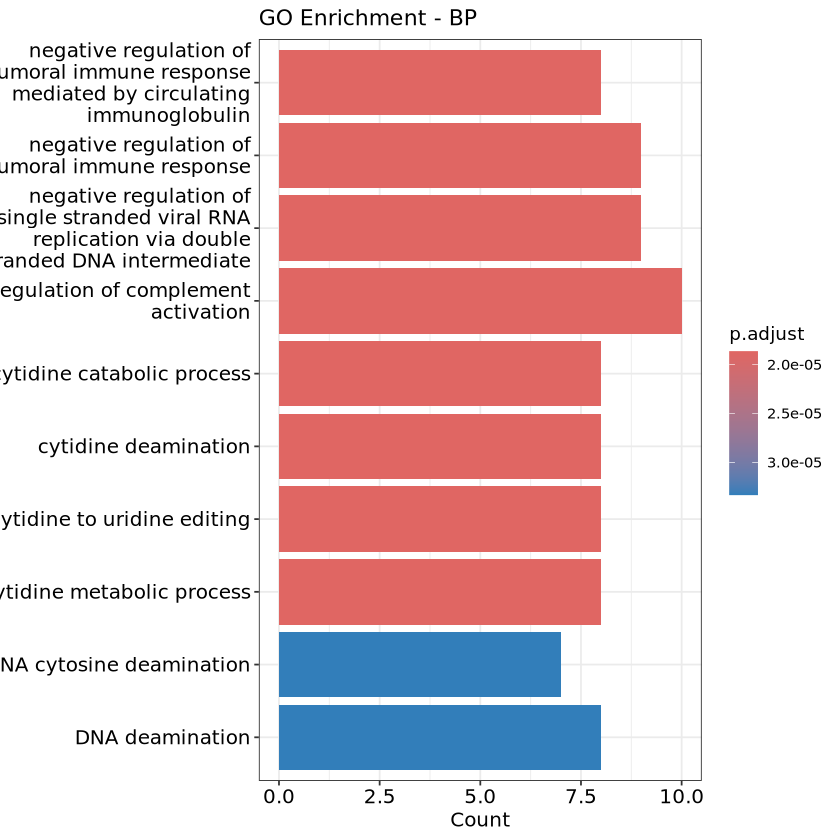

In [143]:
barplot(AD_proxy_ego, showCategory = 10, title = "GO Enrichment - BP")

In [144]:
AD_proxy_ego_cc <- enrichGO(
  gene          = AD_gene,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [145]:
head(AD_proxy_ego_cc, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030017,GO:0030017,sarcomere,23/1082,229/22568,0.0006837531,0.1596803,0.1524488,ENSG00000073712/ENSG00000171992/ENSG00000142661/ENSG00000159176/ENSG00000149925/ENSG00000136717/ENSG00000197361/ENSG00000151150/ENSG00000130528/ENSG00000134571/ENSG00000132912/ENSG00000178209/ENSG00000125744/ENSG00000004939/ENSG00000118046/ENSG00000159173/ENSG00000105048/ENSG00000118194/ENSG00000140416/ENSG00000081248/ENSG00000163395/ENSG00000164591/ENSG00000196923,23
GO:0034364,GO:0034364,high-density lipoprotein particle,7/1082,33/22568,0.0008149478,0.1596803,0.1524488,ENSG00000120885/ENSG00000158874/ENSG00000130208/ENSG00000234906/ENSG00000267467/ENSG00000130203/ENSG00000166035,7
GO:0031594,GO:0031594,neuromuscular junction,11/1082,80/22568,0.0014754678,0.1596803,0.1524488,ENSG00000108556/ENSG00000167193/ENSG00000099617/ENSG00000105467/ENSG00000198087/ENSG00000151150/ENSG00000142192/ENSG00000134569/ENSG00000087085/ENSG00000064300/ENSG00000165917,11
GO:0030667,GO:0030667,secretory granule membrane,32/1082,380/22568,0.0015169047,0.1596803,0.1524488,ENSG00000254415/ENSG00000137845/ENSG00000275019/ENSG00000203710/ENSG00000182310/ENSG00000008283/ENSG00000196352/ENSG00000187908/ENSG00000164855/ENSG00000158869/ENSG00000143226/ENSG00000162747/ENSG00000129450/ENSG00000182264/ENSG00000003147/ENSG00000005961/ENSG00000005844/ENSG00000117335/ENSG00000138161/ENSG00000081277/ENSG00000169228/ENSG00000115257/ENSG00000174992/ENSG00000166900/ENSG00000172270/ENSG00000146094/ENSG00000108219/ENSG00000120306/ENSG00000111644/ENSG00000268500/ENSG00000170458/ENSG00000105383,32
GO:0032994,GO:0032994,protein-lipid complex,8/1082,47/22568,0.0016158425,0.1596803,0.1524488,ENSG00000120885/ENSG00000136717/ENSG00000158874/ENSG00000130208/ENSG00000234906/ENSG00000267467/ENSG00000130203/ENSG00000166035,8
GO:0043292,GO:0043292,contractile fiber,24/1082,260/22568,0.0017085973,0.1596803,0.1524488,ENSG00000073712/ENSG00000171992/ENSG00000142661/ENSG00000159176/ENSG00000149925/ENSG00000136717/ENSG00000197361/ENSG00000151150/ENSG00000180209/ENSG00000130528/ENSG00000134571/ENSG00000132912/ENSG00000178209/ENSG00000125744/ENSG00000004939/ENSG00000118046/ENSG00000159173/ENSG00000105048/ENSG00000118194/ENSG00000140416/ENSG00000081248/ENSG00000163395/ENSG00000164591/ENSG00000196923,24
GO:0042589,GO:0042589,zymogen granule membrane,4/1082,12/22568,0.0019083059,0.1596803,0.1524488,ENSG00000187908/ENSG00000138161/ENSG00000174992/ENSG00000166900,4
GO:0030016,GO:0030016,myofibril,23/1082,250/22568,0.0022000416,0.1596803,0.1524488,ENSG00000073712/ENSG00000171992/ENSG00000142661/ENSG00000159176/ENSG00000149925/ENSG00000136717/ENSG00000197361/ENSG00000151150/ENSG00000130528/ENSG00000134571/ENSG00000132912/ENSG00000178209/ENSG00000125744/ENSG00000004939/ENSG00000118046/ENSG00000159173/ENSG00000105048/ENSG00000118194/ENSG00000140416/ENSG00000081248/ENSG00000163395/ENSG00000164591/ENSG00000196923,23
GO:0042627,GO:0042627,chylomicron,4/1082,13/22568,0.0026524971,0.1596803,0.1524488,ENSG00000158874/ENSG00000130208/ENSG00000234906/ENSG00000130203,4


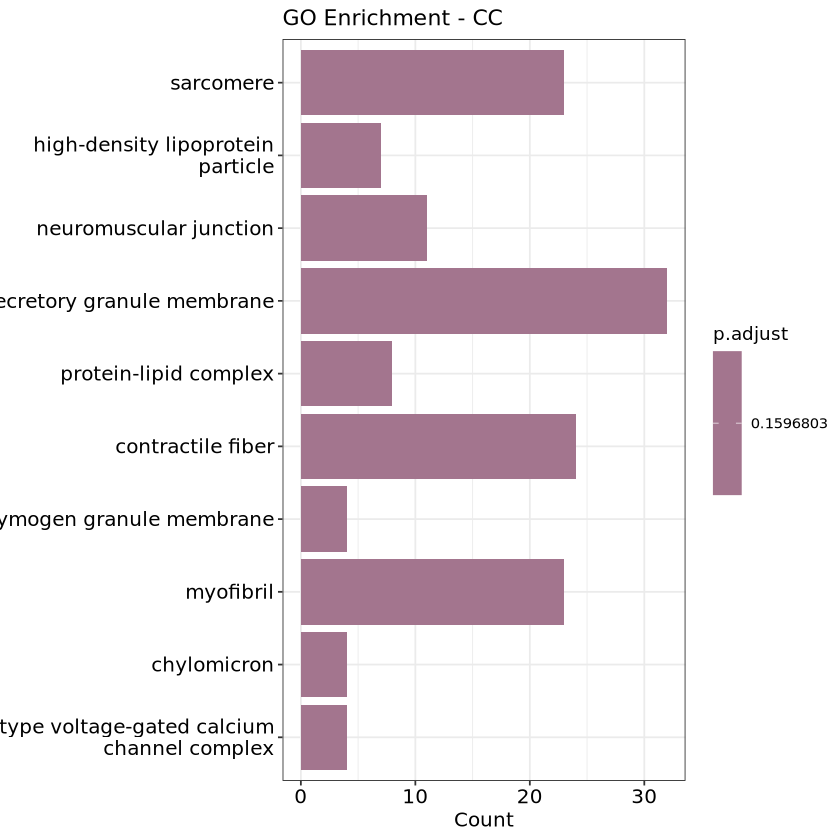

In [146]:
barplot(AD_proxy_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [85]:
ggsave('~/project/image_QTL/image_enrichment/figs/image_AD_sig_xqtl_CC.pdf', width = 6, height = 6)

In [147]:
AD_proxy_ego_mf <- enrichGO(
  gene          = AD_gene,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [148]:
head(AD_proxy_ego_mf, n=5)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004126,GO:0004126,cytidine deaminase activity,8/1023,13/21059,3.124096e-08,2.930402e-05,2.782090e-05,ENSG00000124701/ENSG00000243811/ENSG00000100298/ENSG00000262156/ENSG00000128394/ENSG00000244509/ENSG00000239713/ENSG00000179750,8
GO:0047844,GO:0047844,deoxycytidine deaminase activity,7/1023,10/21059,6.600378e-08,3.095577e-05,2.938905e-05,ENSG00000243811/ENSG00000100298/ENSG00000262156/ENSG00000128394/ENSG00000244509/ENSG00000239713/ENSG00000179750,7
GO:0033691,GO:0033691,sialic acid binding,9/1023,22/21059,4.078523e-07,1.126610e-04,1.069590e-04,ENSG00000254415/ENSG00000168995/ENSG00000129450/ENSG00000105366/ENSG00000268500/ENSG00000142512/ENSG00000254521/ENSG00000105383/ENSG00000105492,9
GO:0017171,GO:0017171,serine hydrolase activity,30/1023,224/21059,4.804307e-07,1.126610e-04,1.069590e-04,ENSG00000167757/ENSG00000129455/ENSG00000185873/ENSG00000159640/ENSG00000131187/ENSG00000167754/ENSG00000167759/ENSG00000213022/ENSG00000197540/ENSG00000187054/ENSG00000142515/ENSG00000167748/ENSG00000167751/ENSG00000198092/ENSG00000185198/ENSG00000087085/ENSG00000129437/ENSG00000186474/ENSG00000115257/ENSG00000174562/ENSG00000115718/ENSG00000169035/ENSG00000167755/ENSG00000166033/ENSG00000129451/ENSG00000095587/ENSG00000182326/ENSG00000184381/ENSG00000153802/ENSG00000167749,30
GO:0004252,GO:0004252,serine-type endopeptidase activity,27/1023,201/21059,1.671474e-06,3.135685e-04,2.976983e-04,ENSG00000167757/ENSG00000129455/ENSG00000185873/ENSG00000131187/ENSG00000167754/ENSG00000167759/ENSG00000213022/ENSG00000197540/ENSG00000187054/ENSG00000142515/ENSG00000167748/ENSG00000167751/ENSG00000198092/ENSG00000185198/ENSG00000129437/ENSG00000186474/ENSG00000115257/ENSG00000174562/ENSG00000115718/ENSG00000169035/ENSG00000167755/ENSG00000166033/ENSG00000129451/ENSG00000095587/ENSG00000182326/ENSG00000153802/ENSG00000167749,27


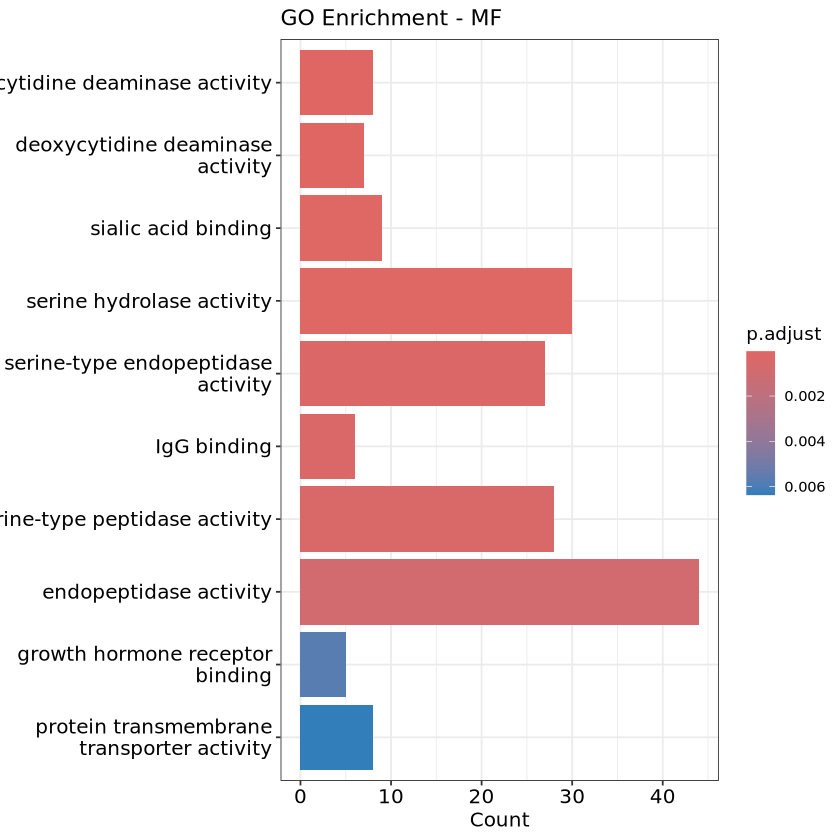

In [149]:
barplot(AD_proxy_ego_mf, showCategory = 10, title = "GO Enrichment - MF")